In [91]:
# for data manipulation
import pandas as pd
import numpy as np

# plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#models to run
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import LabelBinarizer

# train_test split
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score

#save model to file
from sklearn.externals import joblib

#metrics
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_fscore_support 


In [9]:
# read raw data
raw_data = pd.read_csv('/home/sourabh/Downloads/kddcup.data_10_percent1.csv')

In [10]:
raw_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1,0,0.11,0,0,0,0,0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1,0,0.05,0,0,0,0,0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1,0,0.03,0,0,0,0,0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1,0,0.03,0,0,0,0,0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1,0,0.02,0,0,0,0,0,normal.


In [16]:
raw_data.shape

(145585, 42)

In [12]:
# remove ". " from labels
raw_data['label'] = raw_data['label'].apply(lambda x: x[:-1])

In [13]:
raw_data['label'].nunique()

23

In [15]:
# drop duplicate records
raw_data.drop_duplicates(inplace = True)
raw_data.shape

(145585, 42)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

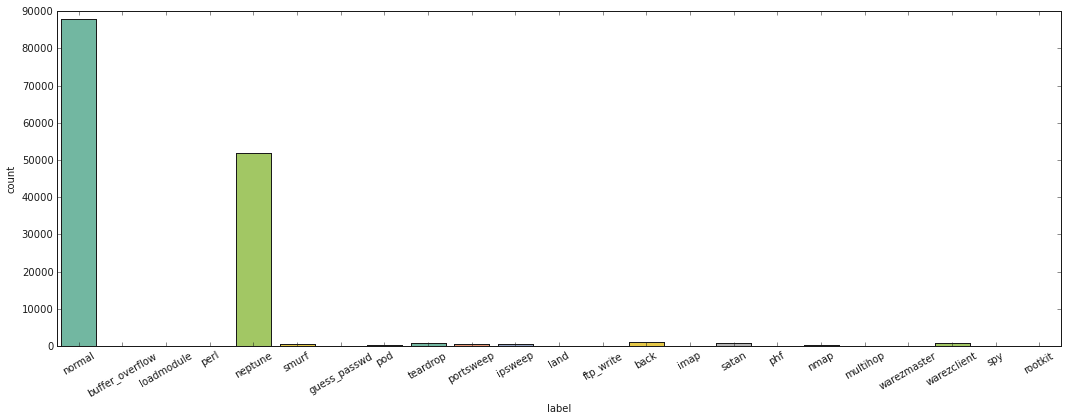

In [18]:
# distribution of labels

sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('label', data = raw_data,palette="Set2", ax = ax1)
plt.xticks(rotation=30)

In [20]:
# combining labels as normal, denial of Service, user to root, remote to local, probes

def label_grouping(label):
    if label in ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']: 
        return 'dos'
    elif label in ['buffer_overflow', 'loadmodule','perl', 'rootkit']:
        return 'utr'
    elif label in ['Ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient', 'warezmaster']:
        return 'rtl'
    elif label in ['satan', 'ipsweep', 'nmap', 'portsweep']:
        return 'probes'
    else:
        return 'normal'

raw_data['label_attack_type']= raw_data['label'].apply(label_grouping)
print(raw_data['label_attack_type'].head())
raw_data['label_attack_type'].value_counts()

0    normal
1    normal
2    normal
3    normal
4    normal
Name: label_attack_type, dtype: object


normal    87839
dos       54572
probes     2131
rtl         991
utr          52
dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

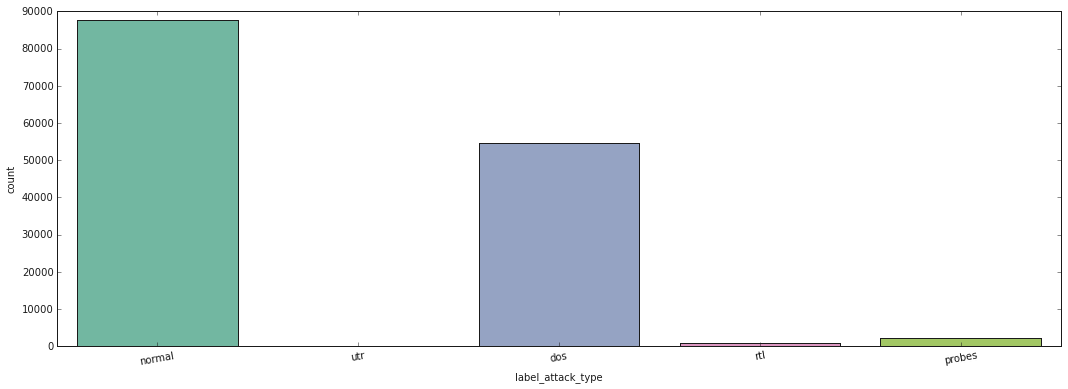

In [21]:
# distribution of label_attack_type

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('label_attack_type', data = raw_data,palette="Set2", ax = ax1)
plt.xticks(rotation=10)

In [22]:
raw_data.columns

Index([u'duration', u'protocol_type', u'service', u'flag', u'src_bytes',
       u'dst_bytes', u'land', u'wrong_fragment', u'urgent', u'hot',
       u'num_failed_logins', u'logged_in', u'num_compromised', u'root_shell',
       u'su_attempted', u'num_root', u'num_file_creations', u'num_shells',
       u'num_access_files', u'num_outbound_cmds', u'is_host_login',
       u'is_guest_login', u'count', u'srv_count', u'serror_rate',
       u'srv_serror_rate', u'rerror_rate', u'srv_rerror_rate',
       u'same_srv_rate', u'diff_srv_rate', u'srv_diff_host_rate',
       u'dst_host_count', u'dst_host_srv_count', u'dst_host_same_srv_rate',
       u'dst_host_diff_srv_rate', u'dst_host_same_src_port_rate',
       u'dst_host_srv_diff_host_rate', u'dst_host_serror_rate',
       u'dst_host_srv_serror_rate', u'dst_host_rerror_rate',
       u'dst_host_srv_rerror_rate', u'label', u'label_attack_type'],
      dtype='object')

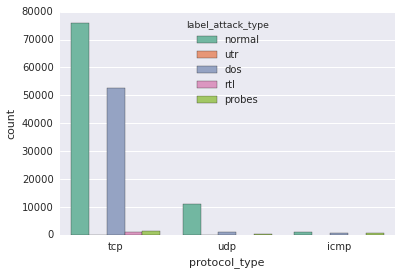

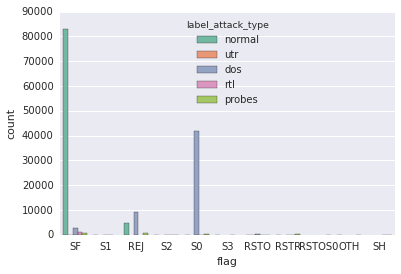

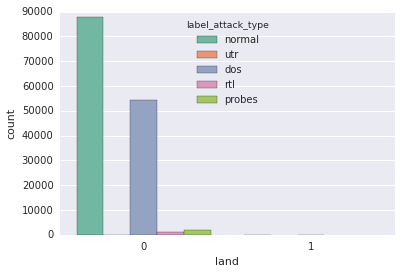

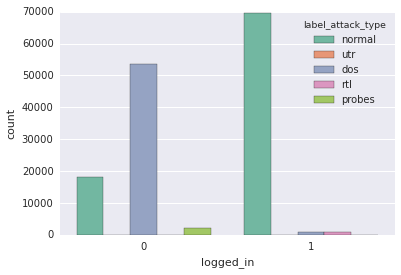

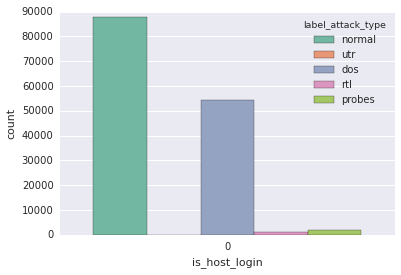

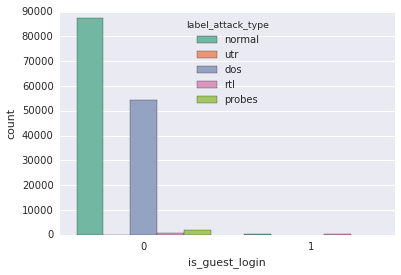

In [24]:
# distribution of categorical variables with 'label_attack_type'
sns.set()
categorical_cols = ['protocol_type','flag','land','logged_in','is_host_login','is_guest_login']

for col in categorical_cols:
    plt.figure()
    sns.countplot(x=col, hue="label_attack_type",data=raw_data, palette="Set2")

In [25]:
def encoding_label(label):
    if label == 'dos':
        return 1
    elif label == 'utr':
        return 2
    elif label == 'rtl':
        return 3
    elif label == 'probes':
        return 4
    else:
        return 0

raw_data['label_encoding']= raw_data['label_attack_type'].apply(encoding_label)
raw_data['label_encoding'].value_counts()

0    87839
1    54572
4     2131
3      991
2       52
dtype: int64

In [27]:
#one hot encoding of categorical variables
flag_encoding = pd.get_dummies(raw_data['flag'],prefix = 'flag')
service_encoding = pd.get_dummies(raw_data['service'],prefix = 'service')
protocol_encoding = pd.get_dummies(raw_data['protocol_type'],prefix = 'protocol')

# concat with original dataframe
raw_data = pd.concat([raw_data, flag_encoding,service_encoding,protocol_encoding],axis =1)

In [28]:
raw_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,protocol_icmp,protocol_tcp,protocol_udp
0,0,tcp,http,SF,181,5450,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Stratified sampling

In [30]:
# split into train and test datasets
# TODO : Add explanation for not using these predictors.
predictors = [c for c in raw_data.columns if c not in ['label', 'label_attack_type', 'index', 'protocol_type',
                                                   'flag','service','is_host_login','label_encoding']]

X = raw_data[predictors]
y = raw_data['label_encoding']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3, stratify = y)

In [31]:
print(y_test.value_counts())

0    26352
1    16372
4      639
3      297
2       16
dtype: int64


In [32]:
print(y_train.value_counts())

0    61487
1    38200
4     1492
3      694
2       36
dtype: int64


##### Evaluation function   
Metrics - Accuracy, precision, recall, F1 score, Confusion matrix, roc_auc 

In [40]:
def get_performance_metrics(y_test,model_predictions):
    # Accuracy
    model_accuracy = accuracy_score(y_test,model_predictions)
    print("Accuracy is ", model_accuracy)

    # precision, recall, f1 score
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_test,model_predictions)
    print('Precision for each class is ', model_precision)
    print('Recall/sensitivity for each class is ', model_recall)
    print('F1 Score for each class is ', model_f1)

    # confusion matrix
    model_confusion_matrix = confusion_matrix(y_test,model_predictions)
    print('confusion matrix is :-->')
    print(model_confusion_matrix)

### Decision Tree

In [44]:
#create instance of decision tree
dt_model = DecisionTreeClassifier(random_state = 3)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [42]:
#making predictions
dt_predictions = dt_model.predict(X_test)

In [43]:
get_performance_metrics(y_test,dt_predictions)

('Accuracy is ', 0.99887810239032881)
('Precision for each class is ', array([ 0.99920298,  0.99987784,  0.78571429,  0.9632107 ,  0.98133748]))
('Recall/sensitivity for each class is ', array([ 0.99905131,  0.99987784,  0.6875    ,  0.96969697,  0.98748044]))
('F1 Score for each class is ', array([ 0.99912713,  0.99987784,  0.73333333,  0.96644295,  0.98439938]))
confusion matrix is :-->
[[26327     2     2     9    12]
 [    2 16370     0     0     0]
 [    3     0    11     2     0]
 [    8     0     1   288     0]
 [    8     0     0     0   631]]


### Using Straified K-Fold Cross Validation (Decision Tree)

maintaining percentage of samples for each class

In [45]:
dt_model = DecisionTreeClassifier(random_state = 3)
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 2)
predictions = []
score = []

for i, (train_index,test_index) in enumerate(skf.split(X,y)):

    train_predictors = X.iloc[train_index]
    train_target = y.iloc[train_index]
    
    test_predictors = X.iloc[test_index]
    test_target = y.iloc[test_index]
    
    #fit the model
    dt_model.fit(train_predictors,train_target)
    
    #make predictions
    test_pred = dt_model.predict(test_predictors)
   
    accuracy = accuracy_score(test_target, test_pred)
    score.append(accuracy)
    
    p, r, f1, support = precision_recall_fscore_support(test_target, test_pred)
    confusion = confusion_matrix(test_target, test_pred)
    
    print('------------------------------')
    print('Accuracy at {0}-Fold is'.format(i),accuracy)
    print('Precision at {0}-Fold is'.format(i), p)
    print('Recall at {0}-Fold is'.format(i), r)
    print('F1 score at {0}-Fold is'.format(i), f1)
    print('Confusion matrix at {0}-Fold is :-->'.format(i))
    print(confusion)
    print('------------------------------')
    
#calculating average accuracy , precision, recall, F1 score   
print('Average accuracy is', np.mean(score))



------------------------------
('Accuracy at 0-Fold is', 0.99894912530135382)
('Precision at 0-Fold is', array([ 0.99924866,  0.99989006,  0.53846154,  0.94985251,  0.99433428]))
('Recall at 0-Fold is', array([ 0.99928279,  0.99994503,  0.38888889,  0.97280967,  0.98734177]))
('F1 score at 0-Fold is', array([ 0.99926572,  0.99991754,  0.4516129 ,  0.96119403,  0.99082569]))
Confusion matrix at 0-Fold is :-->
[[29259     1     5    11     4]
 [    1 18190     0     0     0]
 [    9     0     7     2     0]
 [    7     1     1   322     0]
 [    5     0     0     4   702]]
------------------------------
------------------------------
('Accuracy at 1-Fold is', 0.99903148697659083)
('Precision at 1-Fold is', array([ 0.99911233,  0.99978009,  0.61538462,  0.98461538,  0.99015471]))
('Recall at 1-Fold is', array([ 0.99945355,  0.99967017,  0.47058824,  0.96969697,  0.9915493 ]))
('F1 score at 1-Fold is', array([ 0.99928291,  0.99972512,  0.53333333,  0.97709924,  0.99085151]))
Confusion matr

### Random Forest Model

In [46]:
#stratified sampling

# sss = StratifiedShuffleSplit(n_splits=3, test_size=0.30, random_state=4)
# for train_index, test_index in sss.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

rf_model = RandomForestClassifier(n_estimators=1000,n_jobs = -1, random_state=3)

In [48]:
# fitting data to random forest model
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [49]:
# predictions
rf_predictions = rf_model.predict(X_test)

In [51]:
get_performance_metrics(y_test,rf_predictions)

('Accuracy is ', 0.99924443630369086)
('Precision for each class is ', array([ 0.99897626,  0.99993892,  0.8125    ,  0.99647887,  0.9984127 ]))
('Recall/sensitivity for each class is ', array([ 0.99981026,  0.99993892,  0.8125    ,  0.95286195,  0.98435055]))
('F1 Score for each class is ', array([ 0.99939309,  0.99993892,  0.8125    ,  0.97418244,  0.99133176]))
confusion matrix is :-->
[[26347     1     2     1     1]
 [    1 16371     0     0     0]
 [    3     0    13     0     0]
 [   13     0     1   283     0]
 [   10     0     0     0   629]]


### One vs Rest Classifier

The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [64]:
ovr_dt_model = OneVsRestClassifier(DecisionTreeClassifier(random_state = 3))
ovr_dt_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
          n_jobs=1)

In [65]:
#making predictions
ovr_dt_predictions = ovr_dt_model.predict(X_test)

In [66]:
get_performance_metrics(y_test,ovr_dt_predictions)

('Accuracy is ', 0.99890099825991396)
('Precision for each class is ', array([ 0.99950651,  0.99993891,  0.69230769,  0.98630137,  0.96060606]))
('Recall/sensitivity for each class is ', array([ 0.99916515,  0.9996946 ,  0.5625    ,  0.96969697,  0.99217527]))
('F1 Score for each class is ', array([ 0.9993358 ,  0.99981674,  0.62068966,  0.97792869,  0.97613549]))
confusion matrix is :-->
[[26330     1     3     2    16]
 [    2 16367     0     0     3]
 [    2     0     9     2     3]
 [    4     0     1   288     4]
 [    5     0     0     0   634]]


### One vs One Classifier

This strategy consists in fitting one classifier per class pair. At prediction time, the class which received the most votes is selected. 

In [92]:
ovo_dt_model = OneVsOneClassifier(DecisionTreeClassifier(random_state = 3))
ovo_dt_model.fit(X_train, y_train)

OneVsOneClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
          n_jobs=1)

In [93]:
#making predictions
ovo_dt_predictions = ovo_dt_model.predict(X_test)

In [94]:
get_performance_metrics(y_test,ovo_dt_predictions)

('Accuracy is ', 0.99890099825991396)
('Precision for each class is ', array([ 0.99905167,  0.99987783,  0.66666667,  0.96296296,  0.99055118]))
('Recall/sensitivity for each class is ', array([ 0.99943078,  0.99975568,  0.5       ,  0.96296296,  0.98435055]))
('F1 Score for each class is ', array([ 0.99924119,  0.99981675,  0.57142857,  0.96296296,  0.98744113]))
confusion matrix is :-->
[[26337     0     2     9     4]
 [    2 16368     0     0     2]
 [    6     0     8     2     0]
 [    9     0     2   286     0]
 [    8     2     0     0   629]]


### Addressing imbalance data at the algorithm level, or after it:

#### 1. Adjust the class weight (misclassification costs) for Random Forest

In [81]:
y_train_columns = pd.get_dummies(y_train,prefix = 'label')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3, stratify = y)
Cost_weights = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 100}, {0: 1, 1: 50},{0: 1, 1: 10}]

rf_model = RandomForestClassifier(n_estimators=100,n_jobs = -1, random_state=3, class_weight=Cost_weights)
# fitting data to random forest model
rf_model.fit(X_train,y_train_columns)

# predictions
rf_predictions_df = pd.DataFrame(rf_model.predict(X_test))
rf_predictions_df.head()

,0,1,2,3,4
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0


In [90]:
rf_predictions_df['predict'] =  rf_predictions_df.apply(
                        lambda row: row[0]*0 + row[1]*1+row[2]*2 + row[3]*3 + row[4]*4 , axis=1)
rf_predictions=rf_predictions_df['predict']
get_performance_metrics(y_test,rf_predictions)

('Accuracy is ', 0.99894678999908415)
('Precision for each class is ', array([ 0.99844632,  0.99993891,  0.85714286,  0.99642857,  0.99839486]))
('Recall/sensitivity for each class is ', array([ 0.99984821,  0.99981676,  0.75      ,  0.93939394,  0.97339593]))
('F1 Score for each class is ', array([ 0.99914677,  0.99987783,  0.8       ,  0.96707106,  0.98573693]))
confusion matrix is :-->
[[26348     1     1     1     1]
 [    3 16369     0     0     0]
 [    4     0    12     0     0]
 [   17     0     1   279     0]
 [   17     0     0     0   622]]
